# Capítulo 1
Introdução ao PyTorch e ao dataset CIFAR-10. De prefencia algumas plotagens das imagens desse dataset.

# Treinando um classificador de imagem
1. Carregue e normalize os conjuntos de dados de treinamento e teste CIFAR10 usando *torchvision*
2. Definir uma rede neural convulacional
3. Definir uma loss function
4. Treinar a rede com os dados de treinamento
5. Teste a rede com os dados de teste

In [1]:
# Carregando as bibliotecas que serão usadas

import torch # Usado para construir e treinar redes neurais.
import torch.nn as nn
import torch.optim as optim
import torchvision # Possui utilitários para processamento de dados, como datasets e modelos pré-treinados.
import torchvision.transforms as transforms
import matplotlib.pyplot as plt # Para plotar gráficos e visualizar resultados.
import numpy as np
from tqdm import tqdm # biblioteca para mostrar progresso de looping

In [3]:
# Verifica se uma GPU está disponível
if torch.cuda.is_available():
    device = torch.device("cuda")  # Usar GPU
    print("Usando GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")  # Usar CPU
    print("Usando CPU")

Usando GPU: NVIDIA TITAN X (Pascal)


In [4]:
mean=[0.5, 0.5, 0.5]
std=[0.5, 0.5, 0.5]

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), #expande e realiza um corte na imagem
    transforms.RandomHorizontalFlip(), # Realiza um flip horizontal aleatório na imagem (espelhamento em torno do eixo vertical).
    transforms.ToTensor(), # converte as imagens em tensores
    transforms.Normalize(mean, std) # normaliza os dados
])

transform_test = transforms.Compose([
    transforms.ToTensor(), # converte as imagens em tensores
    transforms.Normalize(mean, std) # normaliza os dados
])

# carregando os dados de treino
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=500, shuffle=True, num_workers=2)

# carregando os dados de teste
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=200, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Explicação:

São usados parametros diferentes no transforms, pois o **treino** do modelo tem a necessidade de ver variações diferentes das imagens para não criar um hábito de vício durante o treinamento, já o **teste**, recebe parametros iguais para estabilizar e dar precisão ao modelo.

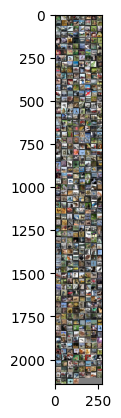

deer  frog  bird  truck ship  horse dog   cat   car   frog  deer  deer  plane horse deer  horse frog  truck plane bird  plane truck frog  ship  ship  car   car   car   horse dog   dog   frog  dog   car   frog  cat   ship  truck bird  bird  dog   ship  car   frog  plane dog   deer  cat   dog   deer  horse deer  frog  plane car   deer  car   frog  plane horse bird  bird  dog   frog  truck horse ship  ship  dog   bird  frog  dog   car   horse frog  truck cat   truck frog  frog  deer  plane horse cat   ship  horse ship  truck horse cat   cat   horse bird  car   plane horse bird  dog   car   deer  frog  ship  cat   deer  truck car   ship  cat   ship  plane plane truck deer  car   cat   deer  truck ship  frog  car   cat   plane horse frog  bird  truck horse cat   dog   frog  bird  bird  cat   truck truck dog   ship  truck plane plane frog  frog  horse bird  bird  dog   horse car   truck truck car   truck car   horse frog  dog   frog  car   deer  ship  car   ship  bird  ship  cat   plane cat 

In [5]:
def mostrar_imagens(img):
  img = (img * 0.5) + 0.5 # Desnormalizar (reverter a normalização) Fórmula: (img * std) + mean
  npimg = img.numpy() # converter tensor para numpy
  plt.imshow(np.transpose(npimg, (1, 2, 0))) # transpor para formato HWC
  plt.show()


# obtendo imagens de treinamento aleatórias
dataiter = iter(trainloader) # iterador para o DataLoader
images, labels = next(dataiter) # obter um batch de imagens e rótulos

# Definir as classes do CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# mostrar imagens
mostrar_imagens(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))

In [6]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 10) # Modifica a última camada para 10 classes (CIFAR-10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/andre/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 51.0MB/s]


Explicação:
* ResNet18: Uma rede neural profunda com blocos de camadas residuais que ajudam a lidar com problemas de degradação em redes muito profundas.
* model.fc: Ajustamos a última camada (fully connected) para que a rede produza 10 saídas, correspondentes às 10 classes do CIFAR-10.

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Explicação:
* CrossEntropyLoss: Calcula a diferença entre as predições do modelo e as classes reais. Essa função é ideal para problemas de classificação multiclasses.
* Adam Optimizer: Atualiza os pesos da rede de forma eficiente, adaptando-se às mudanças na função de perda.

In [8]:
epochs = 5 # número de épocas (quantas vezes o modelo verá o conjunto de treino)

train_losses = []
for epoch in range(epochs):
  model.train() # coloca o modelo em modo de treinamento
  running_loss = 0.0

  for inputs, labels in tqdm(trainloader):

    optimizer.zero_grad() # zera os gradientes acumulados
    outputs = model(inputs) # foward pass: obtem as predições
    loss = criterion(outputs, labels) # calcula a perda
    loss.backward() # backward pass: calcula os gradientes
    optimizer.step() # atualiza os pesos

    running_loss += loss.item() # acumula a perda

  epoch_loss = running_loss / len(trainloader)
  train_losses.append(epoch_loss)
  print(f'Epoch [{epoch + 1} / {epochs}], Loss: {epoch_loss:.4f}')

100%|██████████| 100/100 [04:56<00:00,  2.96s/it]


Epoch [1 / 5], Loss: 1.0127


100%|██████████| 100/100 [04:59<00:00,  3.00s/it]


Epoch [2 / 5], Loss: 0.6730


100%|██████████| 100/100 [04:47<00:00,  2.88s/it]


Epoch [3 / 5], Loss: 0.5828


100%|██████████| 100/100 [04:49<00:00,  2.90s/it]


Epoch [4 / 5], Loss: 0.5286


100%|██████████| 100/100 [04:53<00:00,  2.94s/it]

Epoch [5 / 5], Loss: 0.4910


Explicação:
* num_epochs: Número de épocas define quantas vezes o modelo verá todo o dataset de treinamento.
* model.train(): Coloca o modelo no modo de treinamento, permitindo que os gradientes sejam calculados e os pesos atualizados.
* optimizer.zero_grad(): Zera os gradientes antes de cada iteração, para que eles não sejam acumulados.
* outputs = model(inputs): Passa as imagens através da rede para gerar predições.
* loss.backward(): Calcula os gradientes da função de perda em relação aos pesos.
* optimizer.step(): Atualiza os pesos da rede com base nos gradientes calculados.

In [11]:
correct = 0
total = 0

model.eval() # coloca o modelo em modo de avaliação (desativa o cálculo de gradientes)
with torch.no_grad(): # desativa o cálculo de gradientes durante a avaliação
  for inputs, labels in testloader:
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1) # obtem a classe prevista com a maior probabilidade
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Acurácia no conjunto de teste: {accuracy:.2f}%')


Acurácia no conjunto de teste: 81.15%


Explicação:
* model.eval(): Coloca o modelo em modo de avaliação, onde ele não precisa calcular gradientes.
* torch.no_grad(): Desativa o autograd (backpropagation) para economizar memória durante a avaliação.
* correct e total: Contam quantas previsões a rede acertou e qual o total de amostras avaliadas, respectivamente.

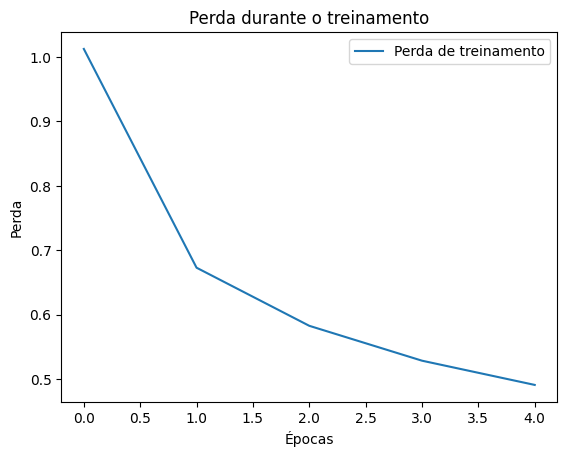

In [12]:
plt.plot(train_losses, label='Perda de treinamento')
plt.title('Perda durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()